# Исследование игровых платформ

**Описание проекта**

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

###  Изучение общей информации

In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker 
from scipy import stats as st

In [84]:
data = pd.read_csv('/datasets/games.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Видим, что в датасете собраны данные по 16715 играм. В некоторых столбцах количество пропусков несущественно, в каких-то - составляет около половины от общего числа наблюдений.

Названия столбцов записаны с использованием верхнего регистра, это может быть неудобно для анализа - приведем все к нижнему регистру. Также в некоторых столбцах заменим тип данных.

###  Предобработка данных 
####  Замена названий столбцов

In [86]:
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

####  Замена типа данных. 

Заменим тип данных в user_score на числовой, приведем critic_score и year_of_release к целочисленному формату. 

In [87]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce').astype('float64')
data['year_of_release'] = pd.to_numeric(data['year_of_release'], errors='coerce').astype('Int64')
data['critic_score'] = pd.to_numeric(data['critic_score'], errors='coerce').astype('Int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   Int64  
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(2), float64(5), object(4)
memory usage: 1.4+ MB


####  Обработка пропусков
Посмотрим в каких столбцах есть пропуски и в каком количестве.

In [88]:
print(data.isna().sum())
data.shape

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64


(16715, 11)

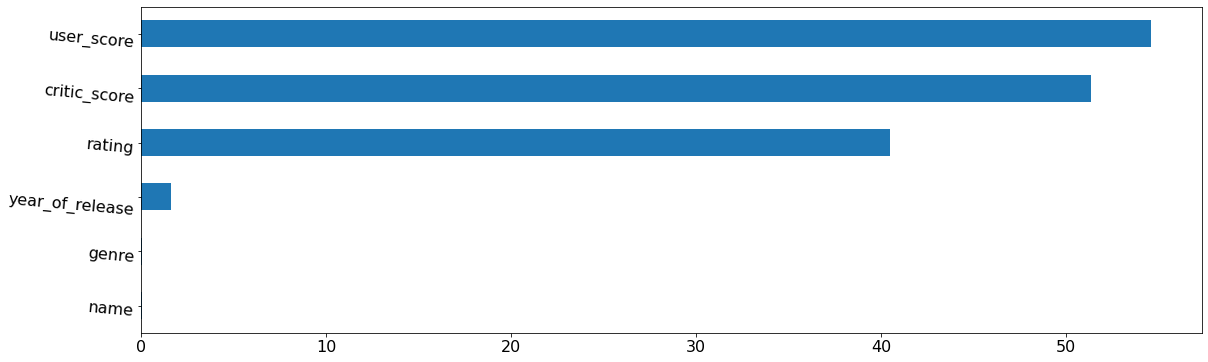

In [89]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16)
                
        );    
    except:
        print('пропусков не осталось :) ')
        
pass_value_barh(data)

**Название и жанр**

В столбцах с названием и жанром по 2 пропуска. Проверим, одни и те же ли это строки. 

In [90]:
data.query('name.isna() and genre.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,<NA>,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,<NA>,NaN,NaN


Данные отсутствуют в одних и тех же сроках. Заполнить их на основании других данных не получится, поэтому просто удалим.

In [91]:
data = data.dropna(subset=['name'])
print(data['name'].isna().sum())
data['genre'].isna().sum()

0


0

**Год выпуска**

Заполнять пропуски данными по той же игре на других платформах было бы не совсем корректно, тк игра могла быть переиздана или представлена в разное время на разных платформах. Количество пропусков равно 1,6%, поэтому тоже их удалим.

In [92]:
data = data.dropna(subset=['year_of_release'])
data['year_of_release'] = pd.to_numeric(data['year_of_release'], errors='coerce')
data['year_of_release'].isna().sum()

0

**Рейтинг**

Посчитаем уникальные значения столбца.

In [93]:
data['rating'].value_counts(dropna=False)

NaN     6676
E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: rating, dtype: int64

K-A является устаревшим обозначением рейтинга Е - заменим его.

Пропуски могут быть связаны с тем, что во времена выхода некоторых игр не было таких требований. Либо эти игры могли не продаваться в Америке, а рейтинговое агентство - американское.

Заполнять пропуски, исходя из рейтинга игры на других платформах не совсем корректно, тк он может отличаться. Заменять их на рейтинг RP ("рейтинг ожидается") тоже было бы неправильным, тк он используется только на рекламных презентациях и в демо-версиях игр до офицальной даты выпуска в продажу. Поэтому пропуски заполним заглушкой NA.

In [94]:
data.loc[data['rating']=='K-A', 'rating'] = 'E'
data.loc[data['rating'].isna(), 'rating'] = 'NA'
print(data['rating'].isna().sum())
data['rating'].value_counts(dropna=False)

0


NA      6676
E       3924
T       2905
M       1536
E10+    1393
EC         8
AO         1
RP         1
Name: rating, dtype: int64

**Оценки**

Значения tbd (подлежит уточнению) в столбце с оценкой пользователей заменим на nan, тк оценка не определена.

Остальные пропуски заполнять не будем. Корректно сделать это не получится, поскольку оценка и так представляет собой среднее всех оценок пользователей/критиков. На разных платформах оценки одной игры также могут различаться.

In [95]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan
data['user_score'].isna().sum()

8981

#### Суммарные продажи

Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.

In [96]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,NA,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,NA,31.38


In [97]:
data.shape

(16444, 12)

#### Дубликаты

Проверим, есть ли явные и скрытые дубликаты в столбцах с названием, платформой и жанром. Для этого приведем все данные к нижнему регистру и выведем уникальные значения по столбцам.

In [98]:
print(data.duplicated().sum())

0


In [99]:
column = ['name', 'platform', 'genre']

for i in column:
    data[i] = data[i].str.lower()
    print('Уникальные значения столбца', i)
    print(data[i].unique())
    print()

Уникальные значения столбца name
['wii sports' 'super mario bros.' 'mario kart wii' ...
 'woody woodpecker in crazy castle 5' 'lma manager 2007'
 'haitaka no psychedelica']

Уникальные значения столбца platform
['wii' 'nes' 'gb' 'ds' 'x360' 'ps3' 'ps2' 'snes' 'gba' 'ps4' '3ds' 'n64'
 'ps' 'xb' 'pc' '2600' 'psp' 'xone' 'wiiu' 'gc' 'gen' 'dc' 'psv' 'sat'
 'scd' 'ws' 'ng' 'tg16' '3do' 'gg' 'pcfx']

Уникальные значения столбца genre
['sports' 'platform' 'racing' 'role-playing' 'puzzle' 'misc' 'shooter'
 'simulation' 'action' 'fighting' 'adventure' 'strategy']



Явных дубликатов нет. скрытых тоже. Нельзя оценить полную картину по столбцу с названиями, но даже если там и неявные дубликаты из-за опечаток и тд, то на результаты это особо не повлияет.

### Исследовательский анализ данных
#### Количество игр в разные годы

Посмотрим, сколько игр выпускалось в разные годы.

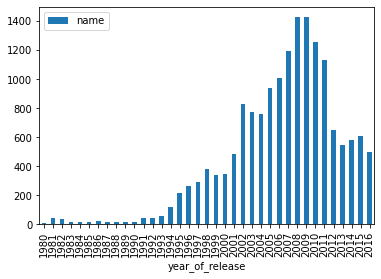

In [100]:
data.pivot_table(index='year_of_release', values='name', aggfunc='count').plot(kind='bar');

Данные по всем периодам не важны, до 1995 года количество выпускаемых игр крайне мало. 

Видим пик в 2008-2009 гг. и резкое падение выпуска после 2010 года. Это может быть связано с возросшим интересом к онлайн играм, либо переход на систему подписок.

#### Продажи по платформам

Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. Определим, за какой характерный срок появляются новые и исчезают старые платформы.

In [101]:
max_sales = data.pivot_table(index='platform', values='total_sales', 
                        aggfunc='sum').sort_values(by='total_sales', ascending=False).reset_index().head(10)
max_sales

,platform,total_sales
0,ps2,1233.56
1,x360,961.24
2,ps3,931.34
3,wii,891.18
4,ds,802.78
5,ps,727.58
6,ps4,314.14
7,gba,312.88
8,psp,289.53
9,3ds,257.81


In [102]:
pivot_platform = data.loc[data['platform'].isin(max_sales['platform'])].pivot_table(index=['platform','year_of_release'], 
values='total_sales', aggfunc='sum').reset_index().sort_values('total_sales', ascending=False)
pivot_platform.head(5)

,platform,year_of_release,total_sales
39,ps2,2004,211.81
77,wii,2009,206.97
37,ps2,2002,205.38
38,ps2,2003,184.31
76,wii,2008,171.32


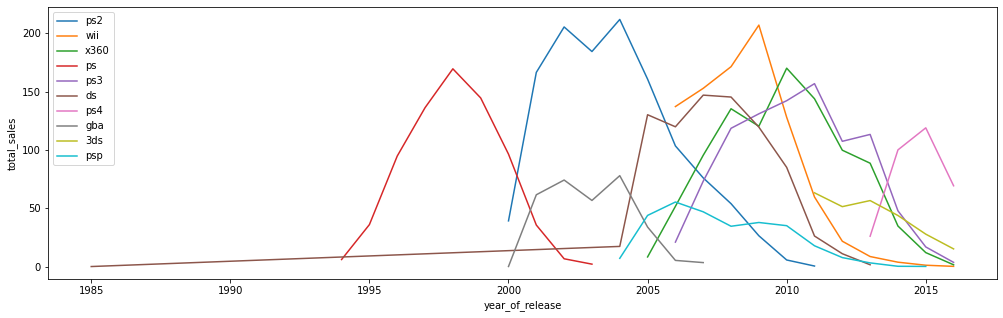

In [103]:
plt.figure(figsize=(17,5))
for i in pivot_platform['platform'].unique():
    sns.lineplot(data = pivot_platform.loc[pivot_platform['platform'] == i], 
                 x = 'year_of_release', y = 'total_sales', label=i)
    plt.legend()

По продажам лидирует платформа ps2, несмотря на то, что уже неактуальна. Видим, что жизненный цикл многих из топ-платформ уже завершен или близится к завершению.

Определим, за какой характерный срок появляются новые и исчезают старые платформы.

In [104]:
platforms = ( 
    pivot_platform[['platform','year_of_release','total_sales']].pivot_table(index='platform', 
        aggfunc={'total_sales':'sum', 
                 'year_of_release':[np.min,np.max,lambda x: np.max(x)-np.min(x)+1]})
    .droplevel(0,axis=1).rename(columns = {
        'amin':'year_first','amax':'year_last',
        '<lambda_0>':'lifetime', 'sum':'total_sales'})
    .sort_values(by='total_sales', ascending=False)
)
display(platforms)
print('Среднее время жизни платформ: {:.2f}'
                 .format(platforms['lifetime'].mean()))

,total_sales,lifetime,year_last,year_first
platform,,,,
ps2,1233.56,12,2011,2000
x360,961.24,12,2016,2005
ps3,931.34,11,2016,2006
wii,891.18,11,2016,2006
ds,802.78,29,2013,1985
ps,727.58,10,2003,1994
ps4,314.14,4,2016,2013
gba,312.88,8,2007,2000
psp,289.53,12,2015,2004


Среднее время жизни платформ: 11.50


В основном платформы имеют 10-12 летний жизненный цикл. Платформа ds явно выбивается из этой статистики, посмотрим что там.

In [105]:
data[data['platform'] == 'ds'].sort_values (by='year_of_release').head(2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,strongest tokyo university shogi ds,ds,1985,action,0.00,0.0,0.02,0.0,<NA>,NaN,NA,0.02
13463,cocoto kart racer,ds,2004,racing,0.04,0.0,0.00,0.0,<NA>,NaN,E,0.04


Судя по всему, ds появилась в 2004 году, значит в первой строке ошибка - удалим ее и обновим график продаж по годам. Не будем заново выводить время жизни платформ - для ds жизненный цикл составил 9 лет.

In [106]:
data = data.drop(data[data['name'] == 'strongest tokyo university shogi ds'].index)

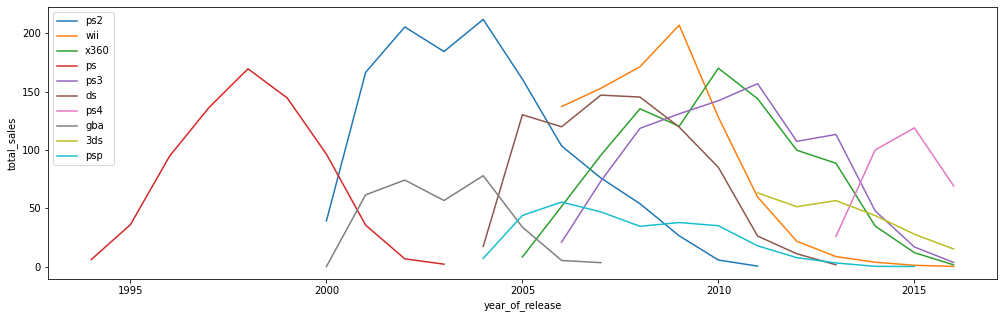

In [107]:
pivot_platform = data.loc[data['platform'].isin(max_sales['platform'])].pivot_table(index=['platform','year_of_release'], 
values='total_sales', aggfunc='sum').reset_index().sort_values('total_sales', ascending=False)

plt.figure(figsize=(17,5))
for i in pivot_platform['platform'].unique():
    sns.lineplot(data = pivot_platform.loc[pivot_platform['platform'] == i], 
                 x = 'year_of_release', y = 'total_sales', label=i)
    plt.legend()

#### Актуальный период и потенциально прибыльные платформы

Исходя из результатов выше, актуальным периодом выберем 2014-2016 гг. Индустрия компьютерных игр - динамична, поэтому большой временной интервал не подойдет. 

In [108]:
actual_data = data.query('year_of_release > 2013')
actual_data.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000,718.000000,888.000000,1689.000000
mean,2014.953227,0.168182,0.160261,0.055115,0.048324,72.306407,6.623536,0.431883
std,0.799624,0.446134,0.466846,0.211513,0.141790,12.213500,1.589792,1.056109
min,2014.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.200000,0.010000
25%,2014.000000,0.000000,0.000000,0.000000,0.000000,66.000000,5.800000,0.030000
50%,2015.000000,0.020000,0.020000,0.010000,0.010000,74.000000,7.000000,0.100000
75%,2016.000000,0.120000,0.120000,0.040000,0.040000,81.000000,7.800000,0.350000
max,2016.000000,6.030000,6.310000,3.180000,2.380000,97.000000,9.300000,14.630000


Посмотрим, какие платформы лидируют по продажам, растут или падают и выберем несколько потенциально прибыльных платформ.

In [109]:
top_platforms = pd.pivot_table(actual_data, index = 'year_of_release', columns='platform', 
                               values='total_sales', aggfunc='sum')
top_platforms

platform,3ds,pc,ps3,ps4,psp,psv,wii,wiiu,x360,xone
year_of_release,,,,,,,,,,
2014,43.76,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


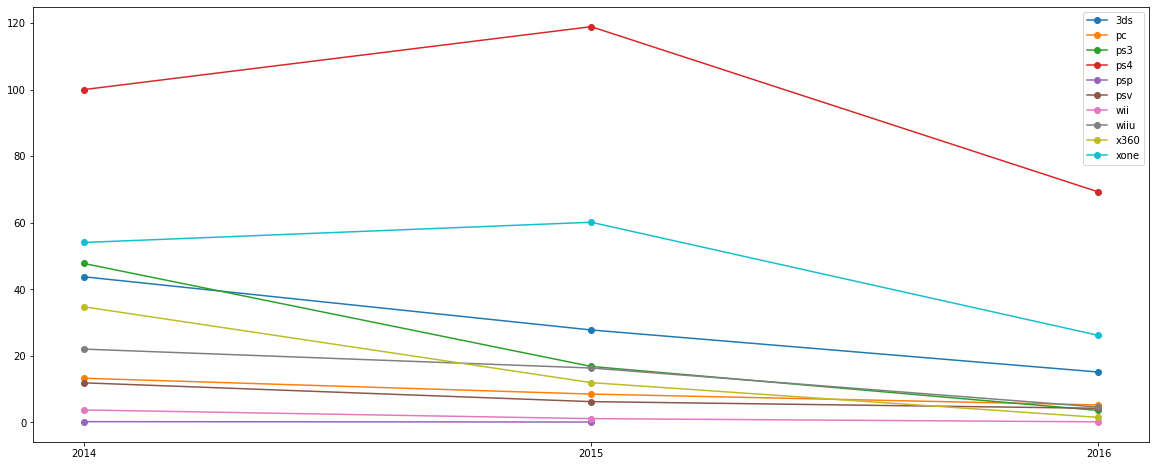

In [110]:
plt.figure(figsize=((20,8)))
plt.plot(top_platforms,  marker = 'o')
plt.legend(top_platforms.columns)
plt.xticks(top_platforms.index.astype(int))
plt.show()

Большую часть рынка занимают платформы ps4 и xone - до 2015 года они растут, в отличие от других платформ. У psp стабильно низкие продажи (с 2015 года их нет), похожая ситуаци и с wii, pc, psv. Еще с 2014 года виден сильный спад у pc3, 3ds, х360. После 2015 года продажи всех платформ начали падать, это может быть связано с переходом на мобильные игры или систему подписок, как предполагалось ранее. Но у некоторых платформ спад объясняется выходом новой версии (ps3-ps4, x360-xone). Потенциально прибыльными по объемам продаж можно назвать платформы ps4, xone. Если смотреть по стабильности, можно присмотреться к pc, psv, wiiu, 3ds.



####  Глобальные продажи игр по платформам

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

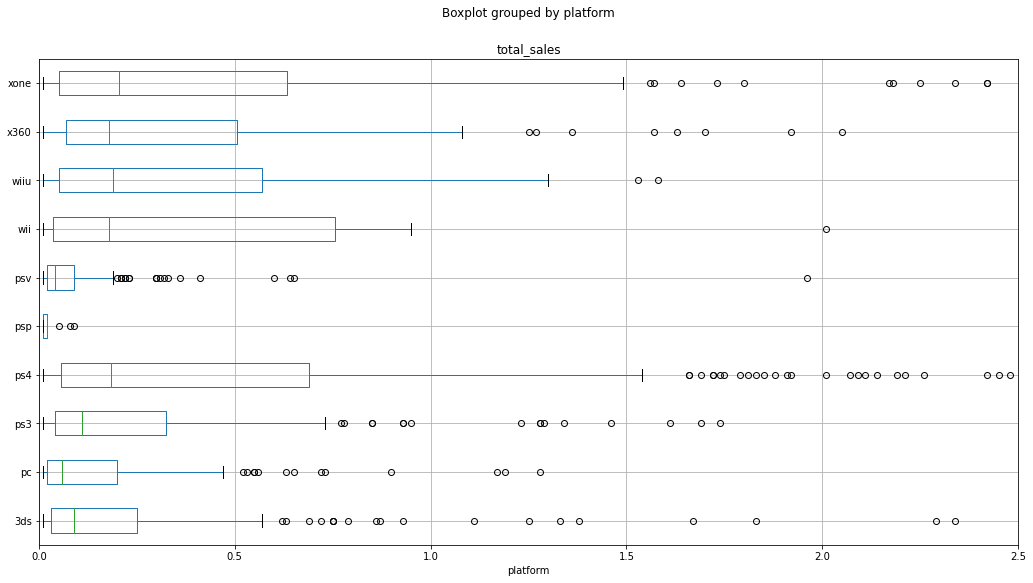

In [111]:
actual_data.boxplot(by='platform', column='total_sales',figsize=(17,9), fontsize=10, grid=True, vert=False);
plt.xlim(0, 2.5);

Видим, что графики по всем платформам скошены вправо. Но в данном случае слишком большие значения не стоит принимать за выбросы, тк так влияют очень популярные игры. Соответственно, больше "выбросов" = потенциально более прибыльные платформы.

Медиана половины платформ находится в районе 0.2, у остальных - 0.1. Наибольшие продажи у ps4, xone, wiiu, хотя 75% продаж больше у wii.



#### Влияние отзывов на продажи

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

Наиболее поплуярной платформой является ps4, рассмотрим ее.

**Оценка критиков**

Коэффицент корреляции = 0.12910710319761823


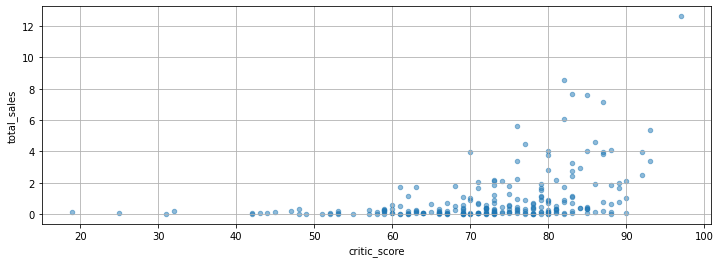

In [112]:
ps4 = actual_data[actual_data['platform'] == 'ps4']
print("Коэффицент корреляции =", ps4['critic_score'].notna().corr(ps4['total_sales']))
ps4.plot(kind='scatter', x='critic_score', y='total_sales', grid=True, figsize=(12,4), alpha = 0.5)
plt.show;

**Оценка пользователей**

Коэффицент корреляции = -0.040131589472697356


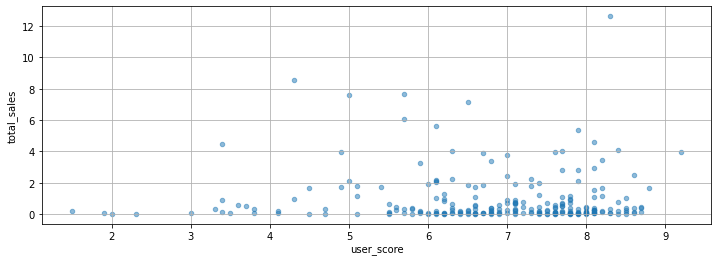

In [113]:
print("Коэффицент корреляции =", ps4['user_score'].corr(ps4['total_sales']))
ps4.plot(kind='scatter', x='user_score', y='total_sales', grid=True, figsize=(12,4), alpha = 0.5)
plt.show;

По диаграммам рассеяния и коэффицентам корреляции видно, что между оценками критиков и продажами игр есть прямая, довльно сильная связь (чем выше оценка, тем больше продаж), в то время как оценка пользователей почти не сказывается на продажах. Возможно, это связано с тем, что на оценки критиков опираются до покупки, а пользователи оценивают игру уже после.

Сравним эти выводы с продажами на других платформах.

In [114]:
other_platforms = actual_data[actual_data['platform'] != 'ps4']
(other_platforms
    .groupby('platform')[['critic_score', 'user_score', 'total_sales']]
    .agg('corr').reset_index()
    .query('level_1 == "total_sales"')
    .reset_index(drop = True)
    .iloc[[0, 1, 2, 4, 5, 6, 7, 8], [0, 2, 3]]
)

,platform,critic_score,user_score
0,3ds,0.314117,0.215193
1,pc,0.174634,-0.071597
2,ps3,0.446575,-0.166761
4,psv,0.042665,-0.168455
5,wii,NaN,1.000000
6,wiiu,0.370201,0.407926
7,x360,0.525723,-0.138445
8,xone,0.428677,-0.070384


In [115]:
#проверка
a = actual_data[actual_data['platform'] == 'wii']
a['user_score'].unique()

array([8.4, nan, 4.3])

Больше всего оценки критиков сказываются на продажи на платформе х360, меньше всего - на psv. На платформе wii совсем отсутствуют оценки критиков и всего пару оценок пользователей - надо бы узнать почему так, а пока не будем делать какие-то выводы по ней.

Оценки пользователей больше всего сказываются на продажах на платформе wiiu, меньше всего - на xone и pc.

Сравнивая ps4 с остальными платформами, приходим к выводу, что на продажи на этой платформе оценки критиков влияют больше, а оценки пользователей меньше, чем на большинстве других платформ.



#### Распределение по жанрам

Посмотрим на общее распределение игр по жанрам.

In [116]:
actual_data['genre'].value_counts()

action          619
role-playing    221
adventure       185
sports          161
shooter         128
misc            113
racing           69
fighting         60
simulation       44
platform         38
strategy         37
puzzle           14
Name: genre, dtype: int64

Больше всего игр издается в жанре action, меньше всего - в жанре puzzle.

Определим, какие из них самые прибыльные и выделяются ли жанры с высокими и низкими продажами. Использовать будем не общие продажи, а медиану, чтобы топовые игры не искажали результат и можно было найти жанр со стабильно высокими продажами.

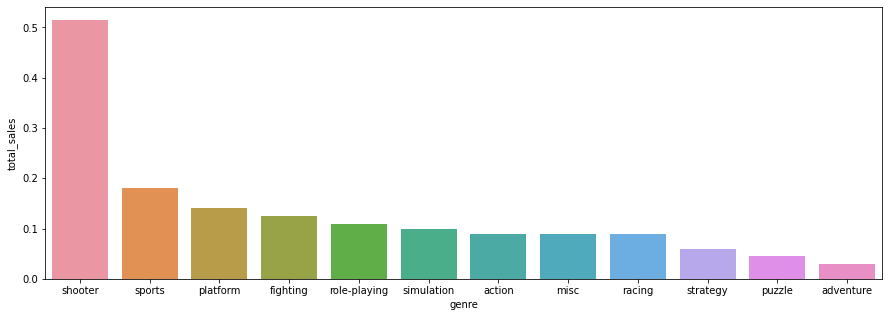

In [117]:
genre = actual_data.pivot_table(index='genre', values='total_sales',
                                  aggfunc='median').sort_values(by='total_sales', ascending=False).reset_index()
plt.figure(figsize=(15,5))
sns.barplot(data=genre, x='genre', y='total_sales');

Самые высокие продажи у жанра shooter, также можно выделить sport и platform. Самые низкие продажи у жанров adventure и puzzle.



### Портрет пользователя каждого региона
#### Самые популярные платформы

Определим топ-5 популярных платформ в каждом из регионов (NA, EU, JP). 

In [118]:
na_platform = actual_data.groupby('platform')['na_sales'].sum().sort_values(ascending=False).head(5)
eu_platform = actual_data.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).head(5)
jp_platform = actual_data.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head(5)

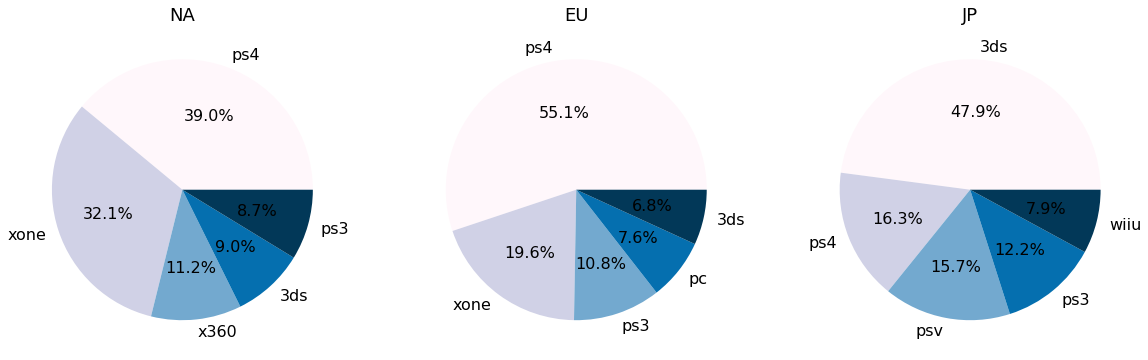

In [119]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

na_platform.plot(kind='pie', ax=ax1, subplots=True, autopct='%1.1f%%', fontsize=16, cmap = 'PuBu')
ax1.set_title('NA', fontsize=18)
ax1.set_ylabel('');

eu_platform.plot(kind='pie', ax=ax2, subplots=True, autopct='%1.1f%%', fontsize=16, cmap = 'PuBu')
ax2.set_title('EU', fontsize=18)
ax2.set_ylabel('');

jp_platform.plot(kind='pie', ax=ax3, subplots=True, autopct='%1.1f%%', fontsize=16, cmap = 'PuBu');
ax3.set_title('JP', fontsize=18)
ax3.set_ylabel('');

В Северной Америке и Европе один и тот же лидер - ps4. Доля платформы xone в Северной Америке в 1,5 раза больше, чем в Европе. Платформы 3ds и ps3 есть в топе обеих стран, но с небольшим отличием в долях. В топе Северной Америки находтся х360 - в Европе ее нет, но есть pc.

В Японии лидирует 3ds. Далее с небольшим процентным различием идут ps4, psv и замыкает топ платформ ps3, wiiu.

Видно, что рынок компьютерных игр в Японии сильно отличается от североамериканского и европейского.



#### Самые популярные жанры

Определим топ-5 популярных жанров в каждом из регионов (NA, EU, JP).

In [120]:
na_genre = actual_data.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head(5)
eu_genre = actual_data.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head(5)
jp_genre = actual_data.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head(5)

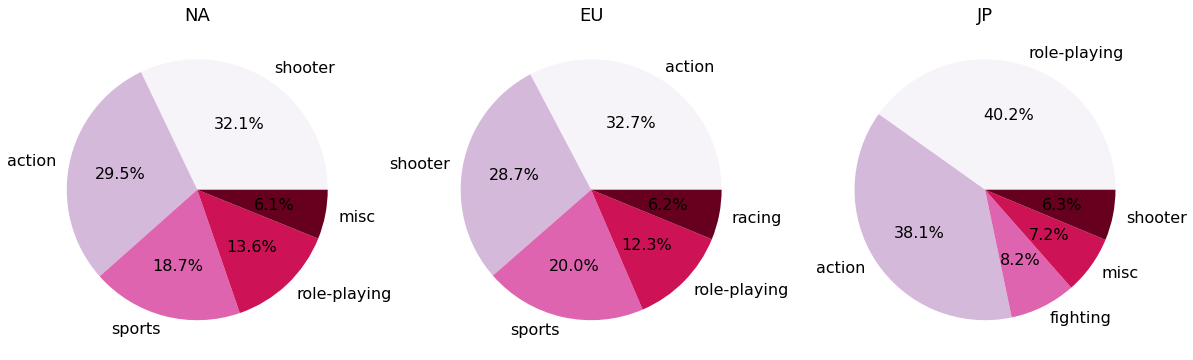

In [121]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

na_genre.plot(kind='pie', ax=ax1, subplots=True, autopct='%1.1f%%', fontsize=16, cmap='PuRd')
ax1.set_title('NA', fontsize=18)
ax1.set_ylabel('');

eu_genre.plot(kind='pie', ax=ax2, subplots=True, autopct='%1.1f%%', fontsize=16, cmap='PuRd')
ax2.set_title('EU', fontsize=18)
ax2.set_ylabel('');

jp_genre.plot(kind='pie', ax=ax3, subplots=True, autopct='%1.1f%%', fontsize=16, cmap='PuRd');
ax3.set_title('JP', fontsize=18)
ax3.set_ylabel('');

Топ-5 жанров в Северной Америке и Европе отличается только наименее популярным жанром - в Северной Америке это misc, а в Европе racing. В остальном он идентичен: лидирует shooter, немного отстает action, далее sports и role-playing.

В Японии топ отличается - на первом месте role-playing, далее action (хотя доля от рынка здесь больше, чем Северной Америке и Европе). Эти два жанра захватывают большую часть рынка и оставшиеся места в топе делят fighting, misc, shooter.



#### Влияение рейтинга ESRB 

Определим, влияет ли рейтинг ESRB на продажи в отдельном регионе.

In [122]:
na_rating = actual_data.groupby('rating')['na_sales'].sum().sort_values(ascending=False)
eu_rating = actual_data.groupby('rating')['eu_sales'].sum().sort_values(ascending=False)
jp_rating = actual_data.groupby('rating')['jp_sales'].sum().sort_values(ascending=False)

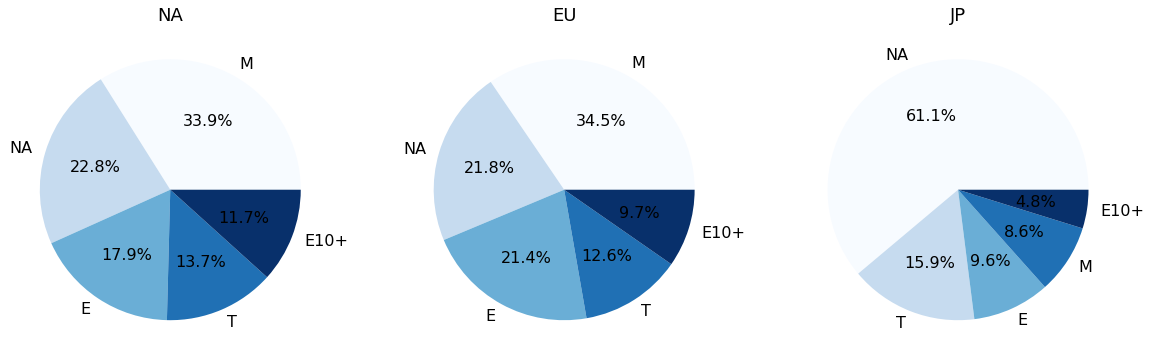

In [123]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

na_rating.plot(kind='pie', ax=ax1, subplots=True, autopct='%1.1f%%', fontsize=16, cmap='Blues')
ax1.set_title('NA', fontsize=18)
ax1.set_ylabel('');

eu_rating.plot(kind='pie', ax=ax2, subplots=True, autopct='%1.1f%%', fontsize=16, cmap='Blues')
ax2.set_title('EU', fontsize=18)
ax2.set_ylabel('');

jp_rating.plot(kind='pie', ax=ax3, subplots=True, autopct='%1.1f%%', fontsize=16, cmap='Blues');
ax3.set_title('JP', fontsize=18)
ax3.set_ylabel('');

В Северной Америке и Европе лучше всего продаются игры с рейтингом М и Е. В Японии же слишком большое количество игр без рейтинга и адекватно оценить картину невозможно. Вероятно там свое рейтингое агентство и рейтинг ESRB на не особо влияет на продажи в этом регионе.



### Проверка гипотез
#### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Сформулируем гипотезу:

Н0: Средний пользовательский рейтинг платформы Xbox One = Средний пользовательский рейтинг платформы PC.

Н1: Средний пользовательский рейтинг платформы Xbox One != Средний пользовательский рейтинг платформы PC.

Критический уровень статической значимости обозначим значением 0.05, сформируем соотвествующие выборки и сравним их средние t-тестом с помощью функции st.ttest_ind, так как выборки независимые.

In [124]:
xone = actual_data[actual_data['platform'] == 'xone']['user_score'].dropna() 
pc = actual_data[actual_data['platform'] == 'pc']['user_score'].dropna()
#удаляем выбросы, потому что с ними дальше функция работает не корректно и выдает р-значение: nan

In [125]:
print('Размер выборки xone:', len(xone))
print('Размер выборки pc:', len(pc))

Размер выборки xone: 165
Размер выборки pc: 122


In [126]:
print('Дисперсия xone:', np.var(xone))
print('Дисперсия pc:', np.var(pc))

Дисперсия xone: 1.8795460055096425
Дисперсия pc: 2.8773743617307175


Размер выборок и дисперсия значительно отличаются, поэтому поставим параметр equal_var=False.

In [127]:
alpha = 0.05

results = st.ttest_ind(xone, pc, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.11601398086668832
Не получилось отвергнуть нулевую гипотезу


Текущей гипотезой остается нулевая, которая говорит о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

#### Средние пользовательские рейтинги жанров Action и Sports разные

Сформулируем гипотезу: 

Н0: Средний пользовательский рейтинг жанра action = Средний пользовательский рейтинг жанра sports.

Н1: Средний пользовательский рейтинг жанра action != Средний пользовательский рейтинг жанра sports.

Критический уровень статической значимости обозначим значением 0.05, сформируем соотвествующие выборки и сравним их средние t-тестом с помощью функции st.ttest_ind, так как выборки независимые.

In [128]:
action = actual_data[actual_data['genre'] == 'action']['user_score'].dropna() 
sports = actual_data[actual_data['genre'] == 'sports']['user_score'].dropna()

In [129]:
print('Размер выборки action:', len(action))
print('Размер выборки sports:', len(sports))

Размер выборки action: 297
Размер выборки sports: 127


In [130]:
print('Дисперсия action:', np.var(action))
print('Дисперсия sports:', np.var(sports))

Дисперсия action: 1.89208448117539
Дисперсия sports: 3.4198375596751185


Размер выборок и дисперсия значительно отличаются, поэтому поставим параметр equal_var=False.

In [131]:
alpha = 0.05

results = st.ttest_ind(action, sports, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута, значит текущей становится альтернативная, которая говорит о том, что средние пользовательские рейтинги жанров Action и Sports действительно разные.

### Вывод

Было проведено исследование данных о продажах игр, оценках пользователей и экспертов, жанрах и платформах, по результатам которого отметим следующие моменты:

В среднем жизненный цикл платформ составляет 10-12 лет. Наиболее актуальный период для анализа данных о продажах игр - 2014-2016 гг., поскольку индустрия компьютерных игр динамична.

Оценки критиков влияют на продажи больше, чем оценки пользователей. Но игры с оценками ниже 5 и от тех и от других продаются плохо.

По продажам на глобальном рынке лидируют платформы ps4 и xone, а жанры - shooter, sports и platform. 

На рынках по регионам ситуация немного отличается:

В Северной Америке и Европе:
- платформы ps4, xone, x360/ps3
- жанры shoother, sports, role-playing
- рейтинг M, E

В Японии:
- платформы 3ds, ps4
- жанры role-playing, action
- рейтинг T (но в целом на рейтинг ESRB ориентироваться не стоит)

Исходя из проверки гипотез:
- Скорее всего средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
- С очень большой вероятностью средние пользовательские рейтинги жанров Action и Sports различаются.